## PBL(1): Individual Project Work

1. https://agtechresearch.pythonanywhere.com/ 에 접속하여 회원가입해 주세요. (비밀번호는 단순하게 만드는 것을 권장. 예: 1234)
2. `username` 에 이메일 형식의 아이디를 기입해 주세요.
3. `password` 에 비밀번호를 기입해 주세요.

## PBL(1): Individual Project Work

1. https://agtechresearch.pythonanywhere.com/ 에 접속하여 회원가입해 주세요. (비밀번호는 단순하게 만드는 것을 권장. 예: 1234)
2. `username` 에 이메일 형식의 아이디를 기입해 주세요.
3. `password` 에 비밀번호를 기입해 주세요.

In [52]:
project = "housingprice"  # 수정하지 마세요
username = "g4312@naver.com"  # 회원가입 시 사용한 이메일아이디 (예시. abc@hello.com)
password = "1234"  # 비밀번호

리더보드 제출을 위한 기본 설정: 아래 코드를 실행해주세요.


In [53]:
import os
import urllib.request

if not os.path.exists("competition.py"):
    url = "https://raw.githubusercontent.com/agtechresearch/LectureAlgorithm/main/competition/competition.py"
    filename = "competition.py"
    urllib.request.urlretrieve(url, filename)

아래 코드를 실행하여 데이터를 다운로드 받습니다: 3개의 csv 파일이 data 폴더에 다운로드됨

 * dataset.csv: 과거 주택매매 데이터 -> 학습에 사용할 데이터셋
 * problem.csv: 현재 A사가 매매를 고려하고 있는 130건의 주택정보 -> ML 모델에 의하여 예측을 수행하여야 할 데이터셋
 * submission.csv: 리더보드 서버 제출을 위한 파일 형식


In [54]:
import competition

# 파일 다운로드
competition.download_competition_files(project)

100%|██████████| 141k/141k [00:00<00:00, 273kiB/s] 


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시
warnings.filterwarnings("ignore")

# Data 경로 설정
DATA_DIR = "data"

In [56]:
# 학습에 사용할 과거 주택매매 data set 로드 (dataset.csv)
dataset = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

# problem set 로드 (problem.csv)
problemset = pd.read_csv(os.path.join(DATA_DIR, "problem.csv"))

In [57]:
# # 결측치가 있다면 GarageType은 NO Garage로, GarageYrBlt의 값은 0으로 대체
dataset["GarageType"].fillna("No Garage", inplace=True)
dataset["GarageYrBlt"].fillna(0, inplace=True)

dataset.isnull().sum()


Id              0
LotArea         0
Street          0
LotConfig       0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageType      0
GarageYrBlt     0
GarageCars      0
GarageArea      0
YrSold          0
SalePrice       0
dtype: int64

In [58]:
#FullBath와 HalfBath를 합쳐서 Bath로 만든다
#YearBuilt는 제거하고, 2024를 YearRemodAdd뺀 Year 열 추가, 이후 YearRemodAdd는 제거
#총 면적을 나타내기 위해 1stFlrSF, 2ndFlrSF, TotalBsmtSF를 합쳐서 TotalFlr로 나타낸다. 나머지는 지운다
#OverallCond제거, Id제거, KitchenAbvGr제거, YrSold제거

dataset["Bath"] = dataset["FullBath"] + dataset["HalfBath"]
dataset["Year"] = 2024 - dataset["YearRemodAdd"]
dataset["TotalFlr"] = dataset["1stFlrSF"] + dataset["2ndFlrSF"] + dataset["TotalBsmtSF"]

#이후 필요없는 열 제거
dataset.drop(["FullBath", "HalfBath", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF",  "Id", "KitchenAbvGr", "YrSold",'Street'], axis=1, inplace=True)

# # problem set 전처리
# # problem set에도 동일한 전처리를 적용한다.
problemset["Bath"] = problemset["FullBath"] + problemset["HalfBath"]
problemset["Year"] = 2024 - problemset["YearRemodAdd"]
problemset["TotalFlr"] = problemset["1stFlrSF"] + problemset["2ndFlrSF"] + problemset["TotalBsmtSF"]
#이후 필요없는 열 제거
problemset.drop(["FullBath", "HalfBath", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF", "Id", "KitchenAbvGr", "YrSold",'Street'], axis=1, inplace=True)


In [59]:
dataset.shape , problemset.shape

((1340, 16), (130, 15))

In [60]:
# GrLIvArea가 4000이상인 이상치 4000으로 대체
dataset.loc[dataset["GrLivArea"] > 4000, "GrLivArea"] = 4000
# LotArea가 100000이상인 이상치 100000으로 대체
dataset.loc[dataset["LotArea"] > 100000, "LotArea"] = 100000


In [61]:
# GarageYrBlt가 0이 아닐시 2024에서 뺀 값으로 대체
dataset.loc[dataset["GarageYrBlt"] != 0, "GarageYrBlt"] = 2024 - dataset["GarageYrBlt"]
# problem set에도 동일한 전처리를 적용한다.
problemset.loc[problemset["GarageYrBlt"] != 0, "GarageYrBlt"] = 2024 - problemset["GarageYrBlt"]





In [62]:
# dataset과 problemset을 합치는데, 섞이지 않게 합친다
all_data = pd.concat([dataset, problemset], ignore_index=True)
# 범주형 변수를 더미화 시킨다
all_data = pd.get_dummies(all_data)


In [63]:
# 학습 데이터와 문제 데이터로 다시 분리
dataset = all_data.iloc[:len(dataset)]
problemset = all_data.iloc[len(dataset):]

In [64]:
dataset.shape, problemset.shape

((1340, 26), (130, 26))

In [65]:
problemset.drop("SalePrice", axis=1, inplace=True)

In [66]:
dataset.shape, problemset.shape

((1340, 26), (130, 25))

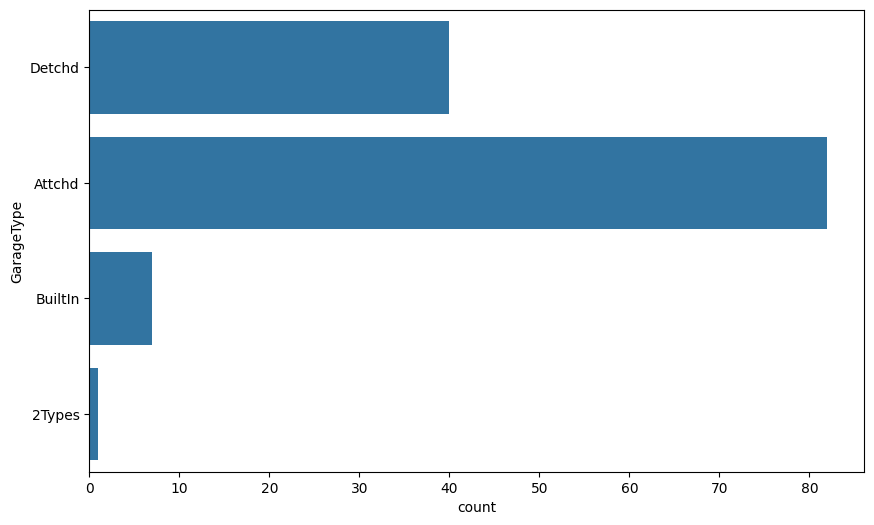

In [51]:
#x_problem의 LotConfig 시각화
plt.figure(figsize=(10, 6))
sns.countplot(problemset["GarageType"])
plt.show()
# 아 그래서 원핫인코딩이...

In [67]:
# 데이터셋 분리
from sklearn.model_selection  import train_test_split
x_train = dataset.drop("SalePrice", axis=1)
y_train = dataset["SalePrice"]
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [70]:
# Random over-sampling 적용
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)



In [71]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8720, 25), (268, 25), (8720,), (268,))

In [76]:
x_problem = problemset

오버샘플링을 하려고 했으나 소수 클래스에 대해 적은 수의 샘플이 있어서 SMOTE 또는 ADASYN이 적절한 이웃을 찾지 못하고 있다
그럼에도 불구하고 오버샘플링은 중요해보인다. 그렇다면 개수가 적은 샘플들은 다른 값으로 치환해 버릴까?

In [77]:
# lightgbm 모델 학습
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
lgb = lgb.LGBMRegressor()
lgb.fit(x_train, y_train)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train set: 8720, number of used features: 23
[LightGBM] [Info] Start training from score 195363.880734


LGBMRegressor()

In [78]:
x_train.shape, x_test.shape , x_problem.shape

((8720, 25), (268, 25), (130, 25))

In [79]:
from sklearn.metrics import mean_squared_error

train_pred = lgb.predict(x_train)
test_pred = lgb.predict(x_test)

print("Train RMSE :", mean_squared_error(y_train, train_pred) ** 0.5)
print("Test RMSE :", mean_squared_error(y_test, test_pred) ** 0.5)

Train RMSE : 6448.584653754007
Test RMSE : 38620.158264489204


In [81]:
problem_pred = lgb.predict(x_problem)

In [82]:
# 리더보드 서버 제출을 위한 파일 생성
submission = pd.read_csv(os.path.join(DATA_DIR, "submission.csv"))
submission["SalePrice"] = problem_pred

# 예측 결과 화면에 출력 후 제출
display(submission)
competition.submit(project, username, password, submission)

,Id,SalePrice
0,1341,124766.323613
1,1342,131054.919415
2,1343,153409.016845
3,1344,134629.813537
4,1345,117156.889332
...,...,...
125,1466,300277.615547
126,1467,210204.448706
127,1468,82526.562572
128,1469,97403.749858


아이디:  g4312@naver.com
파일명:  submissions\20240514-205844-submission.csv
[제출에 성공하였습니다]
제출 결과: 23875.470763345482
